# Generate DET Curves specific to the different subgroups of the Balance Faces in the Wild (BFW) dataset.

Uses the data in `data/bfw-datatable.pkl` to evaluate DET curves of different attributes.

In [14]:
%load_ext autoreload
%autoreload 2
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

sns.set(font_scale=1.1)
# Load out custom tool for loading and processing the data
from facebias.iotools import load_bfw_datatable, makedir
from facebias.visualization import draw_det_curve
from facebias.metrics import calculate_det_curves



%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setings for notebook run
set values per preferences for current session

In [27]:
fontsize=12

# plotting
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

# parameters and filepaths
ticks_to_use_x=(1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0)

# datatable (See Load Data)
dir_data = '../../data/bfw/'
dir_features = f'{dir_data}features/sphereface/'
f_datatable = f'{dir_data}meta/bfw-v0.1.5-datatable.pkl'
use_feature = 'sphereface'

dir_results = f"../../results/{use_feature}/"
makedir(dir_results)


save_plots = True # save plots to disc, in folder 'dir_out'
save_intermediate = True # save data to replot det curves without waiting for calculations
overwrite_existing = False # only save if files do not exist

opts = [{'color': 'g', 'alpha': 0.7, 'norm_hist': True}, {'color': 'r', 'alpha': 0.7, 'norm_hist': True}] # currently not used

/Users/jrobby/WORK/src/facebias/code/facebias/iotools.py:21: UserWarning: Directory ../../results/sphereface/ exists
  warnings.warn(f"Directory {din} exists")


## Load the data

Read in the data as a pandas.DataFrame and display the first few rows.

More information and process to build datatable is exemplified in [0_prepare_datatable.ipynb](0_prepare_datatable.ipynb).

Scores for pairs are assumed to be calculated and added as column of datatable. The process for adding this column is demonstrated in [1_compare_features.ipynb](1_compare_features.ipynb)

**Note** that the demo uses scores from setnet50, as it creates a column *score* with the respective values. Just set *score* column to any set of scores that are intended for analysis.

In [28]:
data = load_bfw_datatable(f_datatable)
data['score'] = data[use_feature]
data.head()

,fold,p1,p2,label,id1,id2,att1,att2,vgg16,resnet50,senet50,a1,a2,g1,g2,e1,e2,sphereface,score
0,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0043_01.jpg,1,0,0,asian_females,asian_females,0.820039,0.703258,0.679089,AF,AF,F,F,A,A,0.392526,0.392526
1,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0120_01.jpg,1,0,0,asian_females,asian_females,0.719199,0.523613,0.594268,AF,AF,F,F,A,A,0.354262,0.354262
2,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0122_02.jpg,1,0,0,asian_females,asian_females,0.732029,0.527567,0.643680,AF,AF,F,F,A,A,0.302028,0.302028
3,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0188_01.jpg,1,0,0,asian_females,asian_females,0.607093,0.348211,0.458883,AF,AF,F,F,A,A,-0.009217,-0.009217
4,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0205_01.jpg,1,0,0,asian_females,asian_females,0.629153,0.384273,0.494913,AF,AF,F,F,A,A,0.132534,0.132534


In [29]:
classes_abbreviated = np.unique(list(np.unique(data.a1)) + list(np.unique(data.a2)))
classes_abbreviated.sort()

print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 8 types: ['AF' 'AM' 'BF' 'BM' 'IF' 'IM' 'WF' 'WM']


In [30]:
subgroups = data.groupby('a1')
li_subgroups = subgroups.groups

In [31]:
def set_det_labels(ax, f_out, save_plots, overwrite):
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    plt.minorticks_off()
    ax.set_ylabel('FNR (%)',fontsize=fontsize+2)
    ax.set_xlabel('FPR', fontsize=fontsize+2)
    ax.legend(fontsize=fontsize)
    ax.set_xlim([1e-4, 1])
    ax.set_ylim([0, 30])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    plt.grid(False)
    if save_plots and overwrite_existing:
        plt.savefig(f"{f_out}.pdf")
        plt.savefig(f"{f_out}.png")

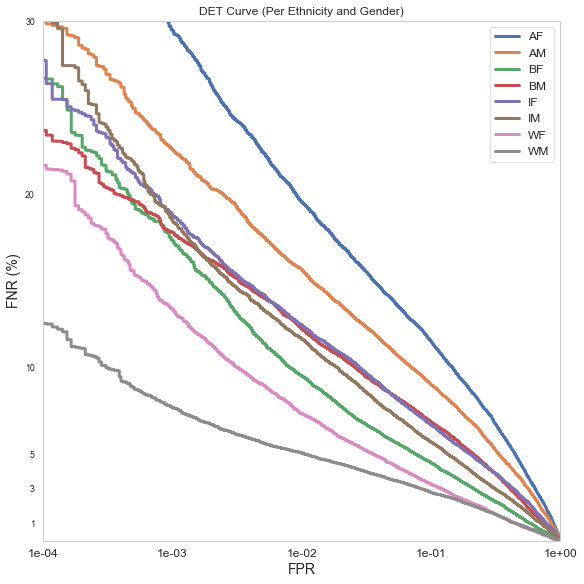

In [32]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_results}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, fnr, thresholds = det_data['fpr'], det_data['fnr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, fnr, thresholds = calculate_det_curves(labels, scores)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'fnr': fnr, 'thresholds': thresholds}, fout)
    ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize,title='DET Curve (Per Ethnicity and Gender)')


set_det_labels(ax0, f"{dir_results}curve_subgroups", save_plots, overwrite_existing)


In [33]:
subgroups = data.groupby('g1')
li_subgroups = subgroups.groups
classes_abbreviated=list(li_subgroups.keys())
print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 2 types: ['F', 'M']


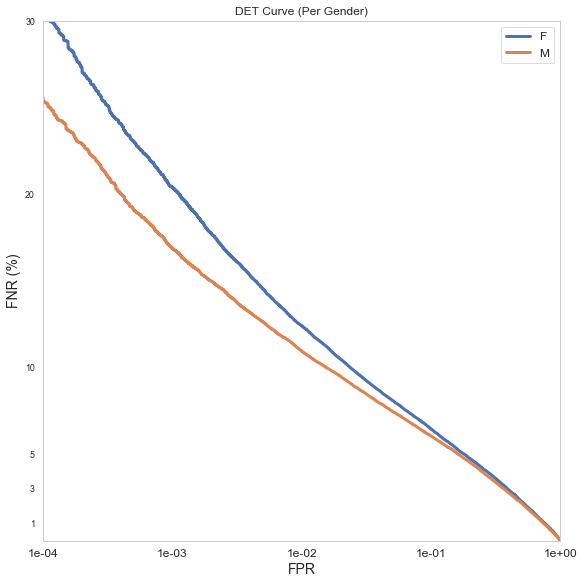

In [34]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_results}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, fnr, thresholds = det_data['fpr'], det_data['fnr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, fnr, thresholds = calculate_det_curves(labels, scores)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'fnr': fnr, 'thresholds': thresholds}, fout)
    ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize, title='DET Curve (Per Gender)')

set_det_labels(ax1, f"{dir_results}curves_gender", save_plots, overwrite_existing)

In [35]:
subgroups = data.groupby('e1')
li_subgroups = subgroups.groups
classes_abbreviated=list(li_subgroups.keys())
print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 4 types: ['A', 'B', 'I', 'W']


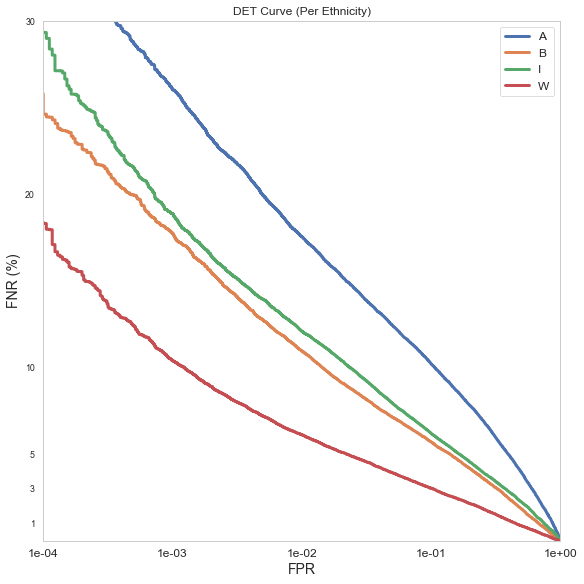

In [36]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_results}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, fnr, thresholds = det_data['fpr'], det_data['fnr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, fnr, thresholds = calculate_det_curves(labels, scores)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'fnr': fnr, 'thresholds': thresholds}, fout)
    ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize, title='DET Curve (Per Ethnicity)')

set_det_labels(ax1, f"{dir_results}curve_ethnicity", save_plots, overwrite_existing)